# CAB420, Week 3 Practical - Question 2 Template
## Multi-Class Classification
In this question we are using the multi-class version of the red wine data, redwine-multiclass.csv, which contains fine-grained quality ratings, but is otherwise the same as the binary data. 

Using this data:
* Train a Random Forest to classify a wine's quality. Select appropriate hyper-parameters for the forest, and evaluate the impact of including class weights.
* Train an ensemble of SVMs to predict a wine's quality. In doing this you should:
  * Train both a one vs one and one vs all model. Comment on differences in performance and training speed.
  * Compare the performance of the two models, while also considering the class imbalance in the data. Explore how the error costs can be changed to improve performance for those classes with limited data.
* Obtain precision, recall and F1 score measures for both classifiers, and compare the results.

### Relevant Examples

The second classification example, ``CAB420_Classification_Example_2_Multi_Class_Classification.ipynb`` is a useful starting point here, as that also deals with multi-class classification.

You may also find ``CAB420_Classification_Additional_Example_Classifier_Parameters_and_Decision_Boundaries.ipynb`` useful if you are uncertain on what impacts hyper-parameters have on performance. ``CAB420_Classification_Example_3_Classification_Metrics.ipynb`` contains details on different classification metrics.

### Suggested Packages

We're leaning on sklearn fairly heavily here. The following imports will give you all you need (and then some), and follow the lecture examples. You are obviously free to use other packages however.

In [1]:
# import all the important packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from scipy.stats import norm

### Step 1

Processing here really is the same as Q1. You need to:
* Load the data, I'd suggest pandas and ``read_csv()`` as we've uesd elsewhere
* Pull out X and Y data. Your Y values are the ``quality`` data series
* Split the data into train and test. I'd suggest ``train_test_split`` from ``sklearn.model_selection``, which will split the data into two sets (i.e. split all data into train and test). If you wish to get three datasets (train, validation, and test), then:
  * Split the data into train and "the rest", using say a 70/30 split
  * Split "the rest" into validation and test, using a 50/50 split  

Following this, standarise your data (or not) depending on what you found in Q1. The data is the same as that used in Q1, just with different labels, so if standardisation was helpful there, it will be helpful here.

It's also recommended to explore the class balance. Plot histograms of the y labels and see how balanced (or not) the dataset is.

(1119, 11)
(1119,)
(240, 11)
(240,)
(240, 11)
(240,)


array([5, 7, 6, 4, 8, 3])

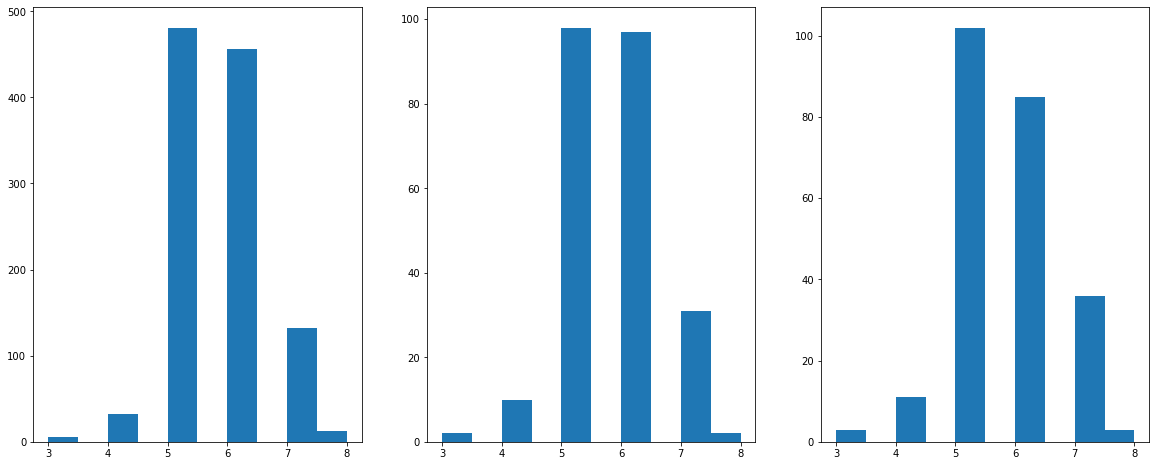

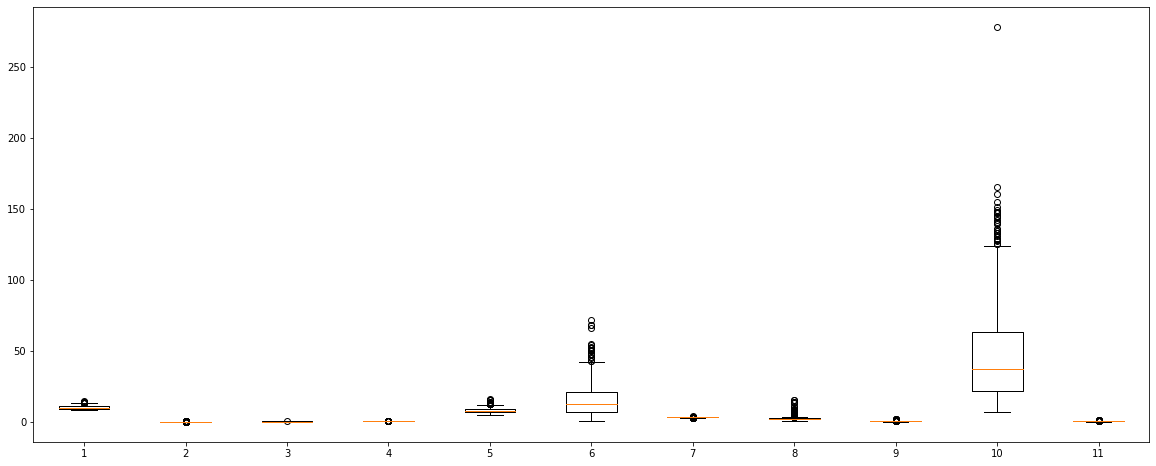

In [22]:
csv = pd.read_csv("redwine-multiclass.csv")
X = csv[csv.columns.difference(["quality"])]
Y = csv["quality"]

# split into 3 sets
X_train, X_other, Y_train, Y_other = train_test_split(X,Y, test_size=0.3, random_state=333)
X_val, X_test, Y_val, Y_test = train_test_split(X_other, Y_other, test_size=0.5, random_state=333)

print(X_train.shape)
print(Y_train.shape)

print(X_val.shape)
print(Y_val.shape)

print(X_test.shape)
print(Y_test.shape)
fig = plt.figure(figsize=[20,8])
ax = fig.add_subplot(1,3,1)
ax.hist(Y_train)

ax = fig.add_subplot(1,3,2)
ax.hist(Y_val)

ax = fig.add_subplot(1,3,3)
ax.hist(Y_test)

fig = plt.figure(figsize=[20,8])
ax = fig.add_subplot(1,1,1)
ax.boxplot(X_train);

Y_train.unique()




### Step 2: Model Fitting

Here you need to:
* Fit a Random Forest, and explore parameter choices. In particular, focus on tree depth and the number of trees. You are also encouraged to explore what happens as enable class weights. As per Q1, you may use:
  * Simple trial and error
  * A grid search, or similar automated search method. Look at ``CAB420_Classification_Example_1_Classification_Three_Ways.ipynb`` for an example of how to use such methods. More information is also available in the [sklearn documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)
* Fit an SVM, and explore parameter choices. In addition to C and your kernal parameters (type and any kernel specific parameters) experiement with one vs one and one vs all encodings (see ``CAB420_Classification_Example_2_Multi_Class_Classification.ipynb`` for an example of what these look like), and the use of class weights.

An evaluation function is provided below, based on what is used in the lecture examples. When considering performance of methods, consider the overall accuracy as well as precision, recall and F1 score. Note that the provided evaluation function will compute all these.

In [17]:
# helper function adapted from lecture examples

# function to do our eval for us, this is quite simple and will
# - create a figure
# - draw a confusion matrix for the trainign data in a sub-fig on the left
# - draw a confusion matrix for the testing data in a sub-fig on the right
# - get precision, recall, f1 for test data
# this has simply been created as we're going to do this for each test that we run
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    conf.ax_.set_title('Training Set Performance: %1.3f' % (sum(model.predict(X_train) == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    conf.ax_.set_title('Testing Set Performance: %1.3f' % (sum(model.predict(X_test) == Y_test)/len(Y_test)));
    print(classification_report(Y_test, model.predict(X_test)))

/opt/conda/envs/cab420-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/cab420-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/cab420-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        11
           5       0.69      0.47      0.56       102
           6       0.41      0.81      0.54        85
           7       1.00      0.03      0.05        36
           8       0.00      0.00      0.00         3

    accuracy                           0.49       240
   macro avg       0.35      0.22      0.19       240
weighted avg       0.59      0.49      0.44       240



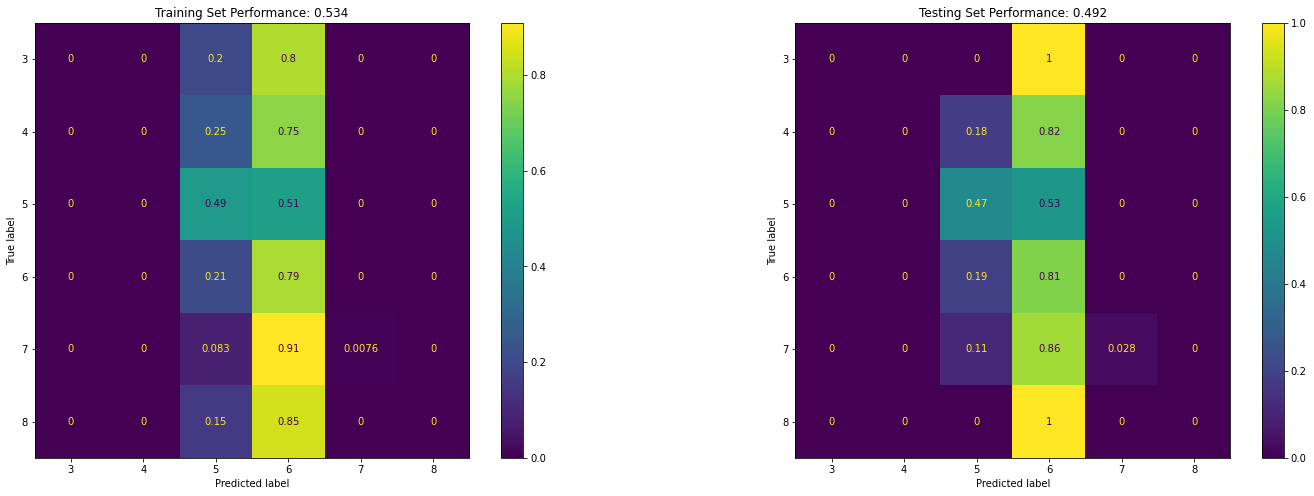

In [26]:
model = SVC(C=2.5, kernel="rbf").fit(X_train,Y_train)

eval_model(model, X_train, Y_train, X_test, Y_test)

/opt/conda/envs/cab420-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/cab420-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/cab420-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        11
           5       0.69      0.79      0.74       102
           6       0.51      0.69      0.59        85
           7       0.71      0.14      0.23        36
           8       0.00      0.00      0.00         3

    accuracy                           0.60       240
   macro avg       0.32      0.27      0.26       240
weighted avg       0.58      0.60      0.56       240



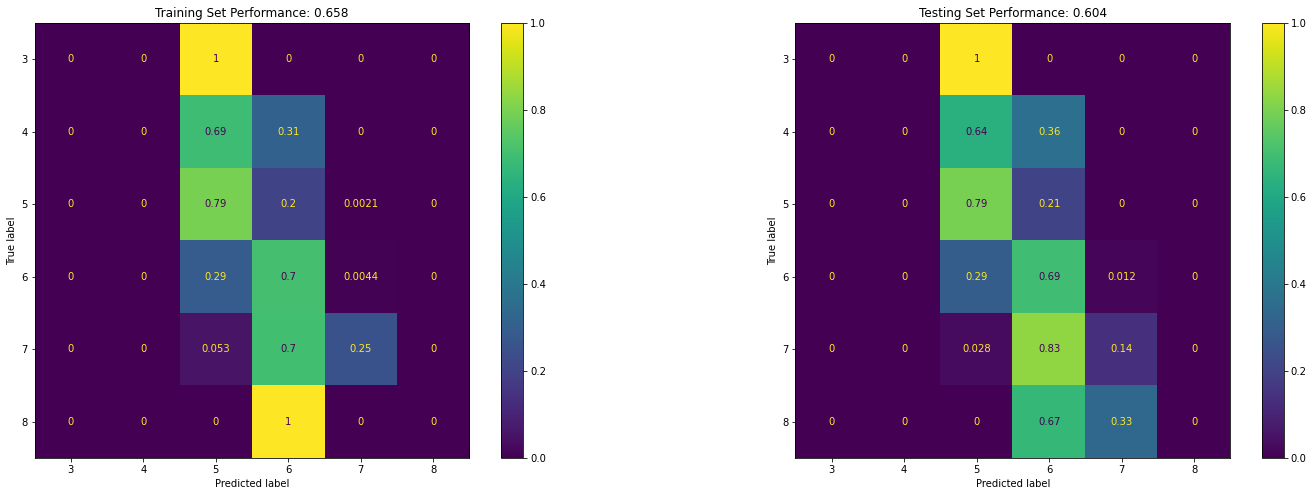

In [27]:
rf = RandomForestClassifier(n_estimators=30, max_depth=4).fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)